In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# KMeans over Songs Features


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Load songs data (Extracted from MongoDB)

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/DATASETS/songs.csv', engine='python')
print(data.describe())
# Drop id to scale features
songs_features = data.drop(['_id'], axis=1)

        Acousticness   Danceability  ...          Tempo        Valence
count  167784.000000  167784.000000  ...  167784.000000  167784.000000
mean        0.501891       0.536703  ...     116.965243       0.526072
std         0.379101       0.175696  ...      30.281912       0.264327
min         0.000000       0.000000  ...       0.000000       0.000000
25%         0.091400       0.415000  ...      93.873000       0.313000
50%         0.524000       0.548000  ...     115.728000       0.538000
75%         0.895000       0.668000  ...     134.999000       0.745000
max         0.996000       0.988000  ...     243.507000       1.000000

[8 rows x 9 columns]


Scaled data to avoid drift on cluster creation

In [ ]:
scaler = StandardScaler()
scaler.fit(songs_features)
X = scaler.transform(songs_features)
print('Scaled data between', X.min(), X.max())

Scaled data between -8.512848918665062 4.67481399763923


Create KMeans models and compute inertia

In [ ]:
# Set up parameters for K-Means
cluster_number = range(1, 21)
# Create models to test k value
models = [KMeans(n_clusters=k) for k in cluster_number]
# Compute Inertia for each model
inertia = [model.fit(X).inertia_ for model in models]

Show the elbow curve

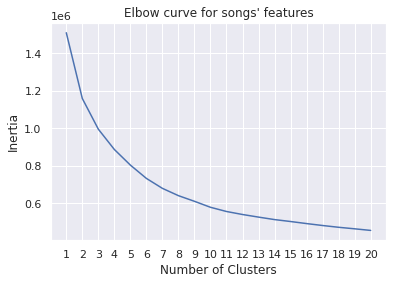

In [ ]:
plt.plot(cluster_number, inertia)
plt.xlabel('Number of Clusters')
plt.xticks(cluster_number)
plt.ylabel('Inertia')
plt.title("Elbow curve for songs' features")
plt.savefig('elbow-curve.png')
plt.show()

K=8 is selected number of cluster. Train model and save it.

In [ ]:
from sklearn.pipeline import Pipeline

print(models[7].inertia_)
pipe = Pipeline([
                 ('scale', scaler),
                 ('model', models[7])
])
pipe

641741.2323525546


Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('model',
                 KMeans(algorithm='auto', copy_x=True, init='k-means++',
                        max_iter=300, n_clusters=8, n_init=10, n_jobs=None,
                        precompute_distances='auto', random_state=None,
                        tol=0.0001, verbose=0))],
         verbose=False)

In [ ]:
genres = pipe.predict(songs_features)
data_genre = data.copy()
data_genre.insert(1, 'Genre', genres)
print(genres.max())

7


Show songs by cluster

In [ ]:
data_genre.groupby('Genre').size()

Genre
0    36312
1    27338
2    10629
3    30377
4    18705
5    11300
6    26020
7     7103
dtype: int64

In [ ]:
data_genre.groupby('Genre').mean()

,Acousticness,Danceability,Energy,Instrumentalness,Liveness,Loudness,Speechiness,Tempo,Valence
Genre,,,,,,,,,
0,0.202022,0.692181,0.671860,0.021413,0.156251,-8.217160,0.082375,111.551222,0.725064
1,0.793727,0.405399,0.234849,0.034963,0.173100,-14.659952,0.046399,101.981947,0.283162
2,0.429440,0.489819,0.618456,0.130965,0.729553,-10.019238,0.104227,119.149117,0.531086
3,0.801133,0.612213,0.359064,0.135930,0.172917,-12.148083,0.078781,121.691412,0.709732
4,0.913559,0.367924,0.172996,0.826560,0.166130,-19.675286,0.052708,101.927296,0.292574
5,0.150735,0.568585,0.730938,0.790132,0.182822,-9.201722,0.064054,126.843326,0.480253
6,0.144272,0.457256,0.735881,0.030954,0.189321,-7.352173,0.076894,143.052325,0.470780
7,0.524941,0.679238,0.242507,0.008935,0.283056,-19.494023,0.908195,107.153143,0.541072


In [ ]:
import joblib

joblib.dump(pipe, '/content/drive/MyDrive/Models/genres_clustering.pkl')

['/content/drive/MyDrive/Models/genres_clustering.pkl']

In [ ]:
model = joblib.load('/content/drive/MyDrive/Models/genres_clustering.pkl')
genres_2 = model.predict(songs_features)
data_genre = data.copy()
data_genre.insert(1, 'Genre', genres_2)
data_genre.groupby('Genre').size()

Genre
0    36312
1    27338
2    10629
3    30377
4    18705
5    11300
6    26020
7     7103
dtype: int64